# Load the entire MNIST digit dataset

In [82]:
# Reference: https://github.com/aferriss/mnist2image/blob/master/mnist.py
import os, struct
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros
from pylab import *
from numpy import *
from PIL import Image
import math

def load_mnist(dataset="training", digits=np.arange(10), path=".", size = 60000):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = size #int(len(ind) * size/100.)
    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(N): #int(len(ind) * size/100.)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])\
            .reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    labels = np.array([label[0] for label in labels])
    return images, labels

In [83]:
train_images, train_labels = load_mnist()

# Choose two digit classes (e.g 7s and 3s) from the training data, and plot some of the examples.

In [68]:
train_images_3 = train_images[train_labels==3]
train_images_7 = train_images[train_labels==7]
print "Picked {} images of digit 3 \nand {} images of digit 7".format(len(train_images_3), len(train_images_7))

Picked 6131 images of digit 3 
and 6265 images of digit 7


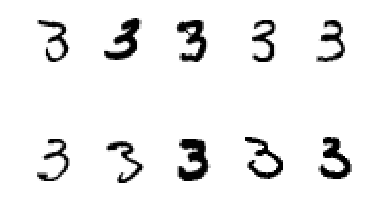

In [69]:
import matplotlib.pyplot as plt
def plot_random(images):
    fig, axs = plt.subplots(2, 5)
    for ax in axs.ravel():
        ax.imshow(images[np.random.randint(len(images))], cmap="gray_r") 
        ax.axis("off")
plot_random(train_images_3)

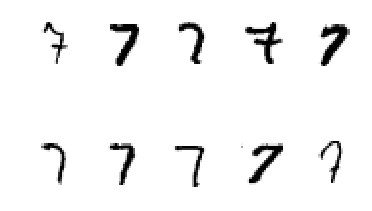

In [70]:
plot_random(train_images_7)

# Train a support vector classifier using each of the following kernels: Linear, Poly, RBF

In [71]:
# Prepare training data; combine and shuffle
from random import shuffle
data = zip(train_images_7, [1]*len(train_images_7))+zip(train_images_3, [0]*len(train_images_3))
shuffle(data)
X, y = zip(*data)
X = np.array(X).reshape(len(y),28*28)

In [80]:
# Measure training time
from sklearn.svm import SVC, LinearSVC
from time import time
kernels = {k:SVC(kernel=k) for k in ["linear", "poly", "rbf"]}
times = {}
for name, model in kernels.items():
    start_time = time()
    model.fit(X,y)
    times[name] = time() - start_time

print times

{'rbf': 378.7521810531616, 'linear': 10.659451007843018, 'poly': 6.508466005325317}


In [84]:
# Load test data
test_images, test_labels = load_mnist(dataset="testing")
test_images_3 = test_images[test_labels==3]
test_images_7 = test_images[test_labels==7]
print "Picked {} images of digit 3 \nand {} images of digit 7".format(len(test_images_3), len(test_images_7))
test_data = zip(test_images_7, [1]*len(test_images_7))+zip(test_images_3, [0]*len(test_images_3))
shuffle(test_data)
test_X, test_y = zip(*test_data)
test_X = np.array(test_X).reshape(len(test_y),28*28)

Picked 1010 images of digit 3 
and 1028 images of digit 7


In [85]:
# Measure error rates
error_rates = {}
for name, model in kernels.items():
    error_rates[name] = 1 - (model.predict(test_X)==test_y).sum()/float(len(test_y))

In [86]:
error_rates

{'linear': 0.023552502453385693,
 'poly': 0.0044160942100097689,
 'rbf': 0.49558390578999023}

It is interesting to observe that although RBF kernel takes the longest training time, its performance is the worst. This might be because the RBF kernel has high degress of freedom in its transformed topology and therefore likely to overfit. Of course, since I only used the default RBF hyperparameters, there is still possibilities that RBF could potentially work better with different regularization and (lower) gamma parameters.

Since our data is very high dimensional (784), using non-linear kernels can lead to the slow down of training process and also potential overfitting problems. (I don't know if this is correct at all, but) I suspect that first using dimensional reduction (to remove redundancy) and then applying non-linear SVM might produce better results.